# Bayesian NN with Laplace Approximations - Binary Classification

The goal of this notebook is to showcase that we can get a better uncertainty quantification via a simple last-layer approximate Bayesian technique. The idea of the method used is as follows: Suppose we have an $L$-layer MAP-trained (deep) ReLU network, we apply a Laplace approximation at **only** the last-layer of the network. That is, the first $L-1$ layers are treated as a fixed feature map $\phi$ and the last-layer is treated as a Bayesian logistic regression with posterior $\mathcal{N}(w^L \mid \mu, \Sigma)$. Since we use a Laplace approximation, we set $\mu := w^L_\text{MAP}$ and $\Sigma := -\nabla^2_{w^L} \log p(w^L \mid D)$, where $D$ is the training dataset. More details will be discussed when we are looking at the actual Laplace approximation code.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.cm as cm
from sklearn import datasets
from math import *
import seaborn as sns; sns.set_style('white')

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['lines.linewidth'] = 1.0
plt = matplotlib.pyplot

First, we create a toy binary classification dataset $D$.

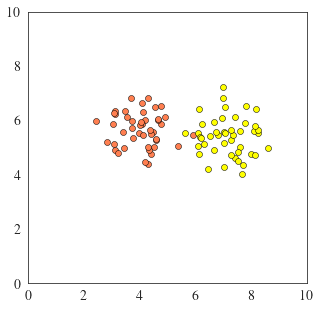

In [2]:
np.random.seed(7777)
size = 90
train_range = (4, 7.5)


X, Y = datasets.make_blobs(n_samples=size, centers=2, cluster_std=0.7, 
                           center_box=train_range, random_state=62)

test_range = (0, 10)

plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)
plt.xlim(test_range);
plt.ylim(test_range);

We will use a three-layer ReLU network and train it using maximum likelihood with weight decay. Note that the weight decay strength can be seen as the Gaussian prior's precision. This is a crucial bit of information for doing the Laplace approximation later on.

In [3]:
torch.manual_seed(7777)

m, n = X.shape
h = 20  # num. hidden units per layer
k = 1  # num. of output unit


class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        self.feature_map = nn.Sequential(
            nn.Linear(n, h),
            nn.BatchNorm1d(h),
            nn.ReLU(), 
            nn.Linear(h, h), 
            nn.BatchNorm1d(h),
            nn.ReLU()
        )

        self.clf = nn.Linear(h, 1, bias=False)
    
    def forward(self, x):
        x = self.feature_map(x)
        return self.clf(x)
    
    
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(Y).float()
    
model = Model()
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

for it in range(5000):
    y_pred = model(X_train).squeeze()
    l = F.binary_cross_entropy_with_logits(y_pred, y_train)
    l.backward()
    opt.step()
    opt.zero_grad()
        
print(f'Loss: {l.item():.3f}')

Loss: 0.030


Here's a plotting function to visualize our results.

In [4]:
def plot(X, Y, X1_test, X2_test, py, conf, size=120):    
    ims = []
    cmap = 'Blues'
    
    plt.figure(figsize=(6, 5))
        
    # Decision boundary contour
    plt.contour(X1_test, X2_test, py.reshape(size, size), levels=[0.5], colors='black', linewidths=[3])

    # Background shade, representing confidence
    conf = np.clip(conf, 0, 0.999999)
    im = plt.contourf(X1_test, X2_test, conf.reshape(size, size), alpha=0.7, 
                      levels=np.arange(0.5, 1.01, 0.1), cmap=cmap, vmin=0.5, vmax=1)
    plt.colorbar(im)

    # Scatter plot the training data
    plt.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='coral', edgecolors='k', linewidths=0.5)
    plt.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='yellow', edgecolors='k', linewidths=0.5)

    plt.xlim(test_range);
    plt.ylim(test_range);
    plt.xticks([])
    plt.yticks([])

    plt.show();

And here's a test dataset, which is just evenly-spaced points in some region of the domain, since we want to predict the confidence of the whole region.

In [5]:
# Test data
size = 50
test_range = (0, 10)
test_rng = np.linspace(*test_range, size)

X1_test, X2_test = np.meshgrid(test_rng, test_rng)
X_test = np.stack([X1_test.ravel(), X2_test.ravel()]).T
X_test = torch.from_numpy(X_test).float()

This is the confidence plot (defined as the maximum probability of each prediction) of the model. This is what we are familiar with and use all the time in deep learning. Notice how the confidence is high (close to one) almost everywhere. Do you think this is a good prediction? Why or why not?

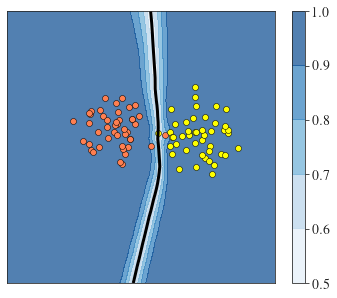

In [6]:
model.eval()


def sigmoid(x):
    return 1/(1+np.exp(-x))


with torch.no_grad():
    model.eval()
    py = sigmoid(model(X_test).squeeze().numpy())
    
conf = np.maximum(py, 1-py)

plot(X, Y, X1_test, X2_test, py, conf, size=size)

Now, let's see whether we can incorporate the model's uncertainty into the prediction. That is, we want to infer the posterior, and use it to marginalize the prediction:

$$
    p(y = 1 \mid x) = \int \sigma(f_\theta(x)) \, p(\theta \mid D) \, d\theta \, , 
$$

where $f_\theta$ is our ReLU network.

One simple way to do this is by doing a Laplace approximation: We approximate the posterior as $\mathcal{N}(\theta \mid \theta_\text{MAP}, H^{-1})$ where $\theta_\text{MAP}$ is the trained weights and $H := -\nabla^2_\theta \log p(\theta \mid D)$ is the Hessian of the negative log-posterior.

However, notice that if the network is large (has many parameters), then $H$ is huge since it scales quadratically to the number of parameters. Here, we make another simplifying assumption: We only apply the Laplace approximation at the _last-layer_. Assume that $\phi$ is the first $L-1$ layers of the network and $w^L$ is the last-layer's weight vector. Then, the prediction is given by:

$$
    p(y = 1 \mid x) \approx \int \sigma({w^L}^\top \phi(x)) \, \mathcal{N}(w^L \mid w^L_\text{MAP}, \Sigma) \, dw^L \, ,
$$

where $\Sigma = (-\nabla^2_{w^L} \log p(\theta \mid D))^{-1}$ is the inverse of the particular sub-matrix of $H$ corresponding to the Hessian of the last-layer.

The previous integral is intractable, so we need a further approximation. One can use the so-called "probit approximation" [1]. First, let's notice that we have an induced Gaussian over the "pre-sigmoid" network's output is $\mathcal{N}({w^L}^\top \phi(x) \mid m, v)$ where $m(x) := {w^L_\text{MAP}}^\top \phi(x)$ is the usual MAP prediction and $v(x) := \phi(x)^\top \Sigma \phi(x)$ is the variance. Then, the probit approximation is simply:

$$
    p(y = 1 \mid x) \approx \sigma \left( \frac{m(x)}{\sqrt{1 + \pi/8 \, v(x)}} \right) \, .
$$


[1] MacKay, David JC. "The evidence framework applied to classification networks." Neural computation 4.5 (1992): 720-736.

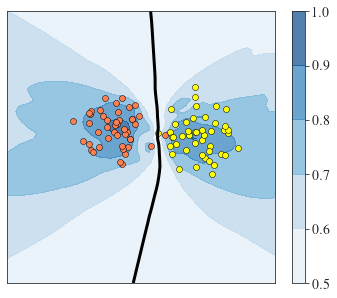

In [10]:
# Exact Hessian using PyTorch's autograd. Credits due to Felix Dangel.
from hessian import exact_hessian


W = list(model.parameters())[-1]
shape_W = W.shape

w_map = W.view(-1).data.numpy()


def neg_log_posterior(var0):
    # Negative-log-likelihood
    nll = F.binary_cross_entropy_with_logits(model(X_train).squeeze(), y_train, reduction='sum')
    # Negative-log-prior
    nlp = 1/2 * W.flatten() @ (1/var0 * torch.eye(W.numel())) @ W.flatten()
    
    return nll + nlp


def get_covariance(var0):
    # Outputs the inverse-Hessian of the negative-log-posterior at the MAP estimate
    # This is the posterior covariance
    loss = neg_log_posterior(var0)
    Lambda = exact_hessian(loss, [W])  # The Hessian of the negative log-posterior
    Sigma = torch.inverse(Lambda).detach().numpy()
    
    return Sigma


@torch.no_grad()
def predict(x, Sigma):    
    phi = model.feature_map(x).numpy()  # Feature vector of x
    m = phi @ w_map  # MAP prediction

    # "Moderate" the MAP prediction using the variance (see MacKay 1992 "Evidence Framework ...")
    # This is an approximation of the expected sigmoid (the so-called "probit approximation")
    v = np.diag(phi @ Sigma @ phi.T)
    py = sigmoid(m/np.sqrt(1 + pi/8 * v))
        
    return py


# The weight decay used for training is the Gaussian prior's precision
# Here we work in term of variance, which is just 1/precision.
var0 = 1/5e-4 

# Get the posterior covariance and make prediction
Sigma = get_covariance(var0)
py = predict(X_test, Sigma)

conf = np.maximum(py, 1-py)

plot(X, Y, X1_test, X2_test, py, conf, size=size)